In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import BaggingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error


In [2]:
dataset = pd.read_csv('/Users/cding/My Drive/ISYE 7406 - Group Project/cleaned_melbourne_housing.csv')
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21729 entries, 0 to 21728
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         21729 non-null  object 
 1   Rooms          21729 non-null  int64  
 2   Type           21729 non-null  object 
 3   Price          21729 non-null  float64
 4   Date           21729 non-null  object 
 5   Distance       21729 non-null  float64
 6   Postcode       21729 non-null  int64  
 7   Bathroom       21729 non-null  float64
 8   Car            21729 non-null  float64
 9   Landsize       21729 non-null  float64
 10  Lattitude      21729 non-null  float64
 11  Longtitude     21729 non-null  float64
 12  Propertycount  21729 non-null  float64
 13  log_price      21729 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 2.3+ MB


In [3]:
#Remove unneeded columns
dataset.drop("Suburb",axis=1,inplace=True) #Lat and long for location
dataset.drop("Price",axis=1,inplace=True)
dataset.drop("Date",axis=1,inplace=True)
dataset.drop("Postcode",axis=1,inplace=True)  #Lat and long for location

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21729 entries, 0 to 21728
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          21729 non-null  int64  
 1   Type           21729 non-null  object 
 2   Distance       21729 non-null  float64
 3   Bathroom       21729 non-null  float64
 4   Car            21729 non-null  float64
 5   Landsize       21729 non-null  float64
 6   Lattitude      21729 non-null  float64
 7   Longtitude     21729 non-null  float64
 8   Propertycount  21729 non-null  float64
 9   log_price      21729 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.7+ MB


In [25]:
####### Data preprocessing
dataset.head()

#Separate feature types for transformation
num_features = ['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'Lattitude', 'Longtitude', 'Propertycount']
cat_features = ['Type']

# Convert numeric columns to ensure they are treated as continuous
for col in num_features:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

#Create X,Y
features = dataset.columns[0:9]
target = dataset.columns[-1]
X = dataset[features]
y = dataset[target]

#Transform categorial variables into df with the encoder while leaving the numeric as floats
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(drop='first'), cat_features), ('num', 'passthrough', num_features)])
X_transformed = preprocessor.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

#Create test train 70-30
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=17)

In [66]:
#Set parameters for tuning / cv
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=111)
alpha_scores = {}

#Run tuning loop
for alpha in alphas:
    #create pipeline that scales and then fits to LASSO
    lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=10000))
    #CV on lasso
    cv_scores = cross_val_score(lasso_pipeline, X_transformed, y, cv=rkf, scoring='r2', n_jobs=-1)
    #Save the R^2 value for each lambda/alpha
    alpha_scores[alpha] = np.mean(cv_scores)

best_alpha = max(alpha_scores, key=alpha_scores.get)

#Fit lasso model to tuned alpha
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=best_alpha, max_iter=10000))
print(f'Best Alpha: {best_alpha}')
lasso_pipeline.fit(X_train, y_train)

#Get the R^2
lasso_score_r2 = lasso_pipeline.score(X_test, y_test)
print(f'LASSO R^2 {lasso_score_r2}')

#Get the RMSE
rmse = root_mean_squared_error(y_test, lasso_pipeline.predict(X_test))
print(f'RMSE: {rmse}')
print(np.exp(rmse)) #This means the prediction error is off by 16% in log space

Best Alpha: 0.0001
LASSO R^2 0.5002884729915105
RMSE: 0.14837905912994798
1.1599525036259424


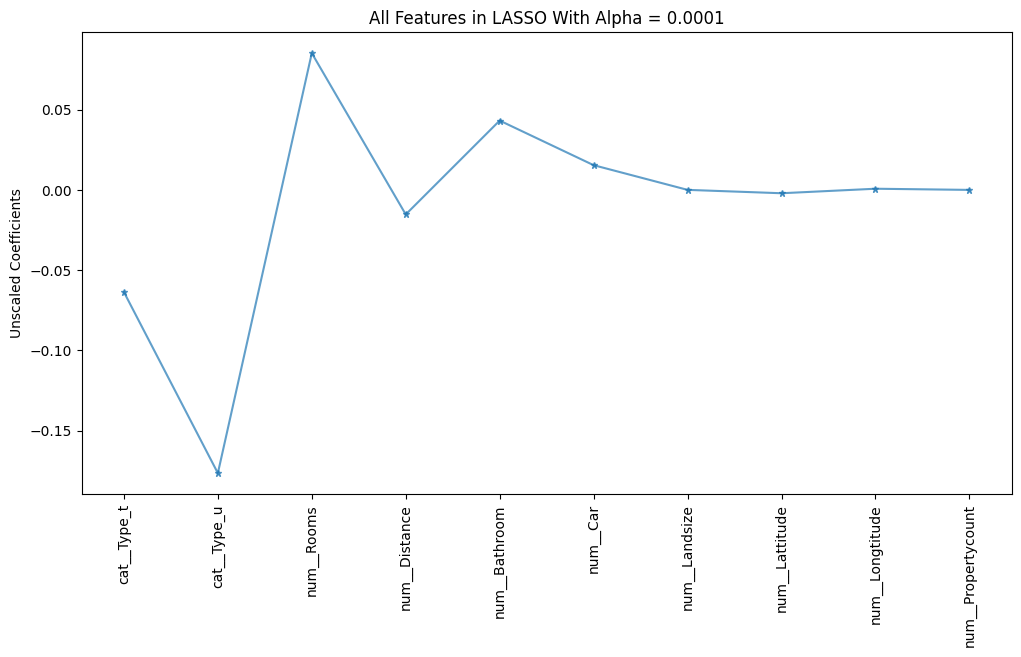

              Feature   Coefficient
2          num__Rooms  8.522683e-02
4       num__Bathroom  4.319492e-02
5            num__Car  1.540344e-02
8     num__Longtitude  7.235211e-04
6       num__Landsize  1.422676e-05
9  num__Propertycount -1.941626e-08
7      num__Lattitude -2.088497e-03
3       num__Distance -1.530810e-02
0         cat__Type_t -6.369194e-02
1         cat__Type_u -1.765483e-01


In [67]:
######### Plot all predictors
encoded_features = preprocessor.get_feature_names_out(features)  # Use preprocessor to get feature names
lasso_model = lasso_pipeline.named_steps['lasso']

# Unscale the coefficients
unscaled_coefs = lasso_model.coef_ / lasso_pipeline.named_steps['standardscaler'].scale_

#Plot Graph
plt.figure(figsize=(12, 6)) 
plt.plot(encoded_features, unscaled_coefs, alpha=0.7, marker='*', markersize=5, zorder=7)
plt.xticks(rotation=90)
plt.title(f'All Features in LASSO With Alpha = 0.0001')
plt.ylabel('Unscaled Coefficients') 
plt.show()

# Print the coefficients
coef_df = pd.DataFrame({'Feature': encoded_features,'Coefficient': unscaled_coefs})
print(coef_df.sort_values(by='Coefficient', ascending=False))

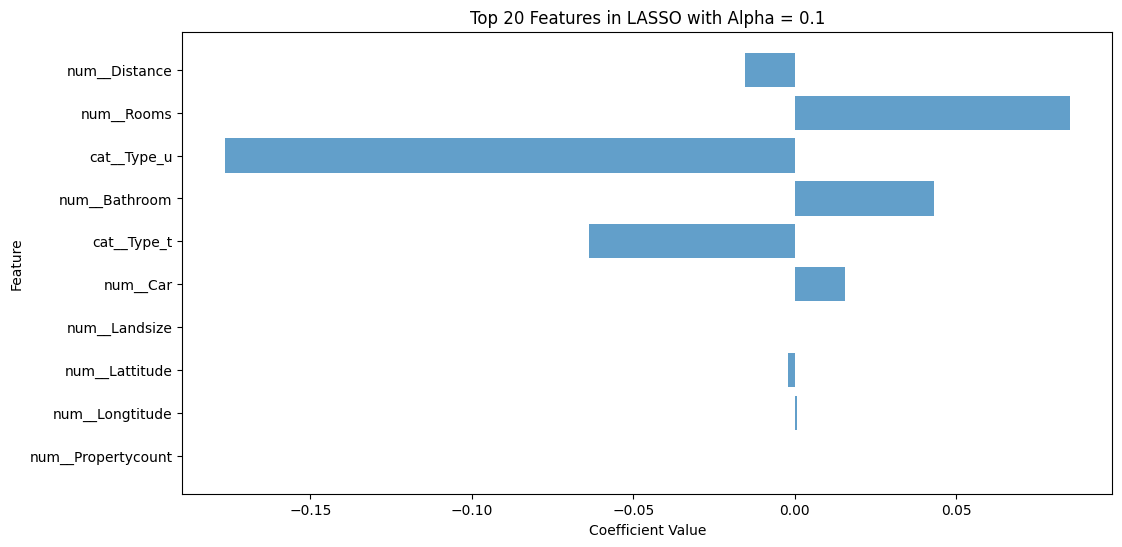

In [46]:
#Same plot but bar graph for visual clarity. Technically unneeded for this version.
lasso_model = lasso_pipeline.named_steps['lasso']

top_indices = np.argsort(np.abs(lasso_model.coef_))[-20:]
encoded_features = preprocessor.get_feature_names_out(features)
unscaled_coefs = lasso_model.coef_ / lasso_pipeline.named_steps['standardscaler'].scale_

# Plot only the top N coefficients
plt.figure(figsize=(12, 6))
plt.barh(encoded_features[top_indices], unscaled_coefs[top_indices], alpha=0.7)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top 20 Features in LASSO with Alpha = 0.1')
plt.show()

In [62]:
#Ridge Regression Model with CV
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=111)
alpha_scores = {}

for alpha in alphas:
    
    ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    cv_scores = cross_val_score(ridge_pipeline, X_transformed, y, cv=rkf, scoring='r2', n_jobs=-1)
    alpha_scores[alpha] = np.mean(cv_scores)

best_alpha = max(alpha_scores, key=alpha_scores.get)

ridge_pipeline = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
print(best_alpha)
ridge_pipeline.fit(X_train, y_train)

ridge_score_r2 = ridge_pipeline.score(X_test, y_test)
print(ridge_score_r2)

#Get the RMSE
rmse_ridge = root_mean_squared_error(y_test, ridge_pipeline.predict(X_test))
print(f'Ridge RMSE: {rmse_ridge}')
print(np.exp(rmse_ridge)) #This means the prediction error is off by 16% in log space

10
0.5002983327285497
Ridge RMSE: 0.1483775952996753
1.1599508056535954


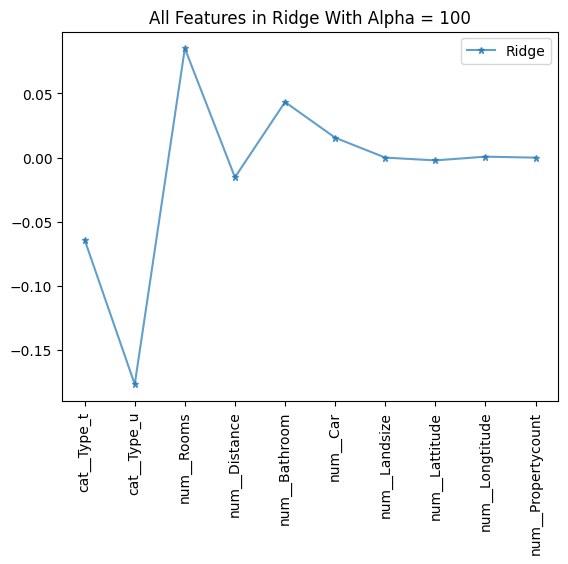

In [49]:
######### Attempt to plot all predictors
encoded_features = preprocessor.get_feature_names_out(features)
ridge_model = ridge_pipeline.named_steps['ridge']

# Unscale data for easy interpretation
unscaled_coefs = ridge_model.coef_ / ridge_pipeline.named_steps['standardscaler'].scale_

plt.plot(encoded_features,unscaled_coefs,alpha=0.7,marker='*',markersize=5,label=r'Ridge',zorder=7)
plt.xticks(rotation = 90)
plt.title(f'All Features in Ridge With Alpha = 10')
plt.legend()
plt.show()

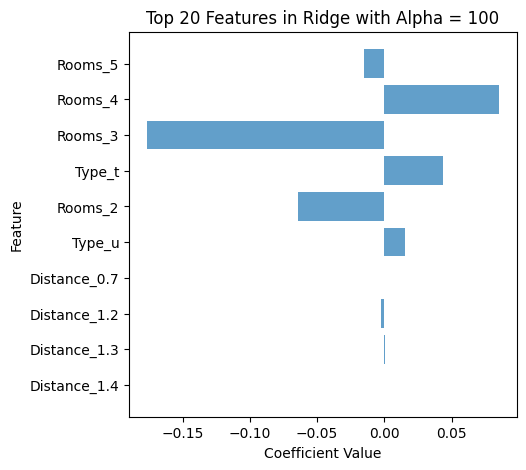

In [50]:
ridge_model = ridge_pipeline.named_steps['ridge']
top_indices = np.argsort(np.abs(ridge_model.coef_))[-20:]

encoded_features = encoder.get_feature_names_out(features)
unscaled_coefs = ridge_model.coef_ / ridge_pipeline.named_steps['standardscaler'].scale_

# Plot only the top N coefficients
plt.figure(figsize=(5, 5))
plt.barh(encoded_features[top_indices], unscaled_coefs[top_indices], alpha=0.7)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top 20 Features in Ridge with Alpha = 100')
plt.show()

In [64]:
# Ridge with Bagging
ridge = Ridge(alpha=100)
bagging_ridge = BaggingRegressor(estimator=ridge, n_estimators=10, random_state=17, n_jobs=-1)
bagging_ridge_pipeline = make_pipeline(StandardScaler(), bagging_ridge)

rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=111)
train_bagging_scores = cross_val_score(bagging_ridge_pipeline, X_train, y_train, cv=rkf, scoring='r2', n_jobs=-1)
#print(np.mean(train_bagging_scores))

bagging_ridge_pipeline.fit(X_train, y_train)

# Unscale the coefficients
bagging_model = bagging_ridge_pipeline.named_steps['baggingregressor']
avg_coefs = np.mean([estimator.coef_ for estimator in bagging_model.estimators_], axis=0)

scaler = bagging_ridge_pipeline.named_steps['standardscaler']
unscaled_coefs = avg_coefs / scaler.scale_
unscaled_intercept = np.mean([estimator.intercept_ for estimator in bagging_model.estimators_]) - np.sum(unscaled_coefs * scaler.mean_ / scaler.scale_)

test_bagging_ridge = bagging_ridge_pipeline.score(X_test, y_test)
print(test_bagging_ridge)

#Get the RMSE
rmse_test_bagging_ridge = root_mean_squared_error(y_test, bagging_ridge_pipeline.predict(X_test))
print(f'Ridge W/Baging RMSE: {rmse_test_bagging_ridge}')
print(np.exp(rmse_test_bagging_ridge)) #This means the prediction error is off by 16% in log space

0.4932502353560609
0.49992296774801137
Ridge W/Baging RMSE: 0.14843331384274547
1.1600154382231191


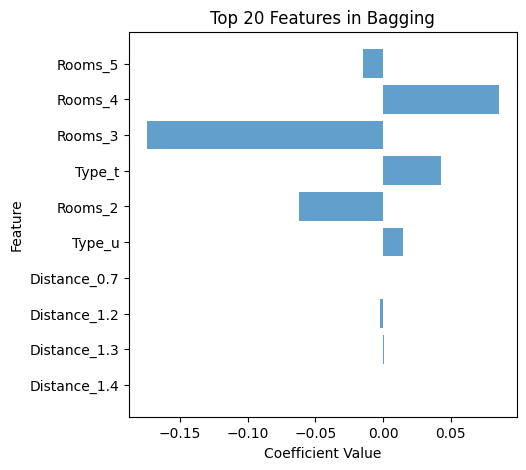

In [65]:
# Plot only the top N coefficients
encoded_features = bagging_ridge_pipeline.named_steps['standardscaler'].get_feature_names_out()
encoded_features = encoder.get_feature_names_out(features)

plt.figure(figsize=(5, 5))
plt.barh(encoded_features[top_indices], unscaled_coefs[top_indices], alpha=0.7)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top 20 Features in Bagging')
plt.show()